# Chapter 13. CNN
* emreged from the study of the brain's visual cortex
* used in image recognition since 1980s
* surpass human capability in visual task

## Visual Cortex
* visual cortex divided into a lot of groups of neurons 
* each group of neurons react to only dedicated recptive field 
* some neurons react to specific features (like horizontal or vertical line)


## Convolutional Layer


![image](res/img/conv_layer_1.png)
* Zero Padding
  * let output image have same size as input
* Stides (vertical & horizontal)
  * offset between two adjacent kernel in convolution
  * reduce image size 

* convolution layer = it's image filter 
  * **neuron = single pixel** in convolution input (which essentially shares same weight and bias with the others within a layer)
  * weight = convolution filter (kernel)
  * output of convolution layer => **called feature map** which highlights pattern similar to kernel(filter)

* CNN Training 
  * like finding useful conv. kernel pattern



## Stacking Multiple Feature Maps

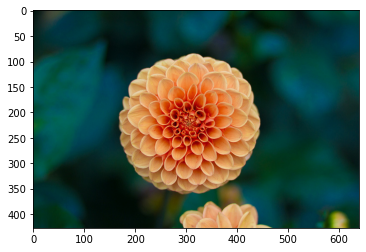

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


0

In [13]:
import numpy as np
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

images = load_sample_images()
images = images.images
flower = images[0]
china = images[1]
plt.imshow(china)
plt.show()

v = np.array([np.array([j for j in range(5)]) for i in range(5) ])
print(v)


[[13. 13. 13. ... 64. 64. 63.]
 [12. 13. 13. ... 64. 65. 65.]
 [12. 12. 13. ... 65. 67. 67.]
 ...
 [40. 40. 37. ... 26. 26. 27.]
 [41. 40. 37. ... 27. 27. 27.]
 [41. 40. 36. ... 28. 28. 27.]]


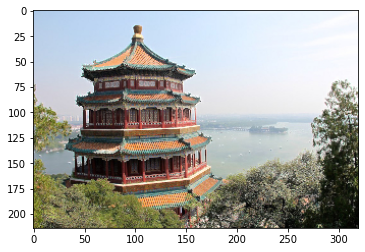

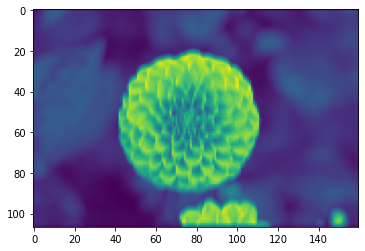

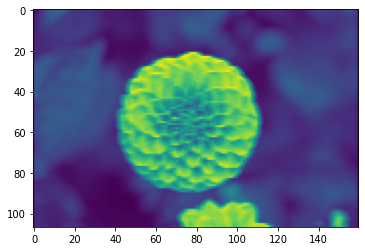

In [3]:
import tensorflow as tf
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

import numpy as np

images = load_sample_images()
images = images.images
flower = images[0]
china = images[1]

dataset = np.array(images, dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

mx_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
convolution = tf.nn.conv2d(mx_pool, filters, strides=[1,2,2,1], padding="SAME", use_cudnn_on_gpu=True)

with tf.Session() as sess:
    mx_output = sess.run(mx_pool, feed_dict={X: dataset})
    output = sess.run(convolution, feed_dict={mx_pool: mx_output})
print(dataset[1,:,:,2])

plt.imshow(mx_output[0].astype(np.uint8))
plt.show()
        
plt.imshow(output[1,:,:,0])
plt.show()
plt.imshow(output[1,:,:,1])
plt.show()


## CNN architecture
  * typically combination of Convolution Layer + Activation + Pooling ... fully connected 
  * there are architecture with proven performance, they are..
    * LeNet-5
    * AlexNet
    * GoogLeNet
    * ResNet

### LeNet-5
  * created by Yann Lecun 
  * used to classifiy MNIST 
  
### AlexNet 
  * first to stack cv layer on top of each other (not pooling layer)
  * regularization 
    * dropout (0.5) used 
    * data augmentation
  * use speicial normalization step called **LRN**
    * keep each feature map apart from others

### GoogLeNet 
  * use special network called **Inception module**
    * less parameters are required to achieve same performance

### ResNet (Residual Network)
  * skip connections 

## Excercise


(8985, 8, 8, 1)
(8985,)


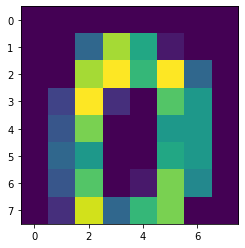

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import numpy as np

digits = load_digits()


def build_shift_image(d):
    r_zeros = np.zeros((1, d.shape[1]))
    c_zeros = np.zeros((d.shape[1], 1))   
    return [np.r_[r_zeros, d[:-1]], np.r_[d[1:], r_zeros], np.c_[c_zeros, d[:,:-1]], np.c_[d[:,1:],c_zeros]]

def expand_data(dataset, labels):
    new_dataset = []
    new_labels = []
    for data, label in zip(dataset, labels):
        new_dataset += build_shift_image(data)
        new_dataset.append(data)
        new_labels += [label for i in range(5)]
    return np.array(new_dataset), np.array(new_labels)


digits_data_raw = np.array(digits['images'])
digits_label = digits['target']

digits_data_raw, digits_label = expand_data(digits_data_raw, digits_label)
digits_data = digits_data_raw.reshape([-1,8,8,1])
print(digits_data.shape)
print(digits_label.shape)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_indices, test_indices in  sss.split(digits_data, digits_label):
    train_data , test_data = digits_data[train_indices], digits_data[test_indices]
    train_label, test_label = digits_label[train_indices], digits_label[test_indices]
    
    
class RandomBatch():
    def __init__(self, data, label, size):
        self.data = data
        self.label = label
        self.b_sz = size
        self.iter_cnt = 0
        self.d_len = len(data)
        
    def __iter__(self):
        self.iter_cnt = 0
        return self
        
    def next(self):
        if self.iter_cnt < (self.d_len / self.b_sz) :
            self.iter_cnt = self.iter_cnt + 1
            choices = np.random.choice(self.d_len, self.b_sz, replace=False)
            return self.data[choices], self.label[choices]
        else:
            raise StopIteration
            
            
plt.imshow(digits_data[0,:,:,0])
plt.show()


In [60]:
# Build MNIST classifier with CNN

import tensorflow as tf
import tensorflow.keras as keras
from datetime import datetime
import numpy as np

tf.reset_default_graph()


batch_size = 50
n_epoch = 150
_, w, h, c = digits_data.shape

X = tf.placeholder(dtype=tf.float32, shape=(None, w, h, c))
Y = tf.placeholder(dtype=tf.int32, shape=(None))
training = tf.placeholder_with_default(False, shape=())
conv_1_feature_n = 32
conv_2_feature_n = 48


random_batch = RandomBatch(train_data, train_label, 10)

with tf.name_scope("network"):
    conv_1 = keras.layers.Conv2D(conv_1_feature_n, 2, strides=1, padding="SAME", input_shape=(8,8,1), activation='relu', name="conv_1")(X)
    conv_2 = keras.layers.Conv2D(conv_2_feature_n, 2, strides=1, padding="SAME", input_shape=(8,8,conv_1_feature_n), activation='relu', name="conv_2")(conv_1)
    avg_pool = keras.layers.AvgPool2D(pool_size=2, strides=2, padding="SAME", input_shape=(8,8,conv_2_feature_n))(conv_2)
    sqzd = tf.reshape(avg_pool, [-1, conv_2_feature_n * w * h / 4])
    drop = tf.layers.dropout(sqzd, 0.5, training=training, name="drop_1")
    d_1 = keras.layers.Dense(conv_2_feature_n * w * h / 4, activation="relu", name="hidden_1")(sqzd)
    d_2 = keras.layers.Dense(conv_2_feature_n * w * h / 2, activation="relu", name="hidden_2")(d_1)
    logits = keras.layers.Dense(10, name="output")(d_2)

    
with tf.name_scope("train"):
    xentropy = tf.losses.sparse_softmax_cross_entropy(labels=Y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    optimizer = tf.train.AdamOptimizer(epsilon=10e-14)
    train_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, Y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
log_writer = tf.summary.FileWriter('/home/tf_logs/cnn_{}_b{}_e{}'.format(datetime.utcnow().strftime("%Y%m%d%H%M%S"),
                                                                            batch_size, 
                                                                            n_epoch), graph=tf.get_default_graph())

last_best_acc = 0
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epoch):
        for x, y in iter(random_batch):
            sess.run(train_op, feed_dict={X:x, Y:y, training: True})
        train_acc = sess.run(accuracy, feed_dict={X:train_data, Y:train_label, training: False})
        test_acc = sess.run(accuracy, feed_dict={X:test_data, Y:test_label, training: False})
        
        summary = tf.summary.Summary()
        summary.value.add(tag="test_acc", simple_value=test_acc)
        summary.value.add(tag="tarin_acc", simple_value=train_acc)
        log_writer.add_summary(summary, epoch)
        print(epoch)
    saver.save(sess, '/home/tf_logs/cnn_mnist.ckpt')
log_writer.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


### 2. Image Classification using inception v3

In [207]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import numpy as np

panda = plt.imread('/home/data/images/Grosser_Panda.jpeg')
hammer = plt.imread('/home/data/images/hammer_head.webp')


data = np.array([hammer, hammer],dtype=np.float32)
print(data.shape)

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, None,None, 3], name="X")
rszd_x = tf.image.resize_image_with_pad(X, 299, 299)

with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(rszd_x, num_classes=1001, is_training=False)
    
    
predictions = end_points["Predictions"]
init = tf.global_variables_initializer()
saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, '/home/tf_logs/model/inception_v3.ckpt')
    rsz_image = sess.run(rszd_x, feed_dict={X:data})
    pred_val = sess.run(predictions, feed_dict={X:data})
    saver.save(sess, '/home/tf_logs/inception.ckpt')




(2, 512, 768, 3)
INFO:tensorflow:Restoring parameters from /home/tf_logs/model/inception_v3.ckpt


In [208]:
np.argmax(pred_val[1])

726

### 3. Transfer learning using inception v3

### 4. DeepDream tutorial